Notebook to look at the Bathymetry that NEMO actually uses after it does its processing

In [1]:
from __future__ import division
import matplotlib.patches as mpatches
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.collections import PatchCollection
import netCDF4 as nc
import numpy as np
from salishsea_tools import bathy_tools
%matplotlib inline

In [2]:
# read the bathymetry that we specify and send into NEMO
sb_filepath = '../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
spec_bathy = nc.Dataset(sb_filepath, 'r')
spec_depth = spec_bathy.variables['Bathymetry']

In [3]:
# read the bathymetry that NEMO puts out after one time step
nc_filepath = '../../NEMO-forcing/grid/grid_bathy.nc'
bathy = nc.Dataset(nc_filepath, 'r')
depth = bathy.variables['grid_bathy']
dep_d = bathy.variables['deptht']
lon_d = bathy.variables['nav_lon']
lat_d = bathy.variables['nav_lat']
print depth.shape

(40, 898, 398)


In [4]:
# and get some salinity data to plot
gT_filepath = '/data/dlatorne/MEOPAR/SalishSea/nowcast/14dec14/SalishSea_1d_20141214_20141214_grid_T.nc'
gT = nc.Dataset(gT_filepath, 'r')
sal_d = gT.variables['vosaline']

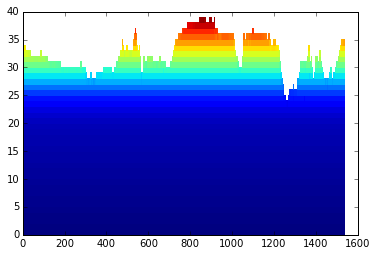

In [5]:
# read the thalweg
lines = np.loadtxt( 'thalweg_working.txt', delimiter=" ", unpack=False)
lines = lines.astype(int)

# find values along the thalweg and plot the depth
thalweg_lon = lon_d[lines[:,0],lines[:,1]]
thalweg_lat = lat_d[lines[:,0],lines[:,1]]
thalweg_depth = depth[:,lines[:,0],lines[:,1]]
thalweg_spec = spec_depth[lines[:,0],lines[:,1]]

plt.pcolormesh(thalweg_depth)

(300, 400)

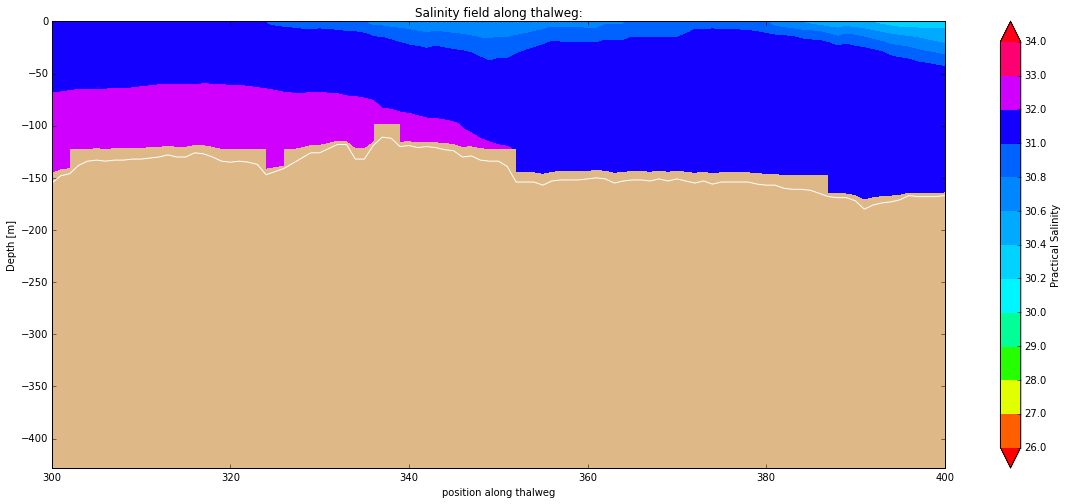

In [6]:
# do the classic thalweg plot over a section, using NEMO depths, but note: this is contour plot
cs = [26,27,28,29,30,30.2,30.4,30.6,30.8,31,32,33,34]
ds = np.arange(0,lines.shape[0],1);
XX, ZZ = np.meshgrid(ds,-dep_d[:])
salP=sal_d[0,:,lines[:,0],lines[:,1]]
salP= np.ma.masked_values(salP,0)

fig, ax = plt.subplots(1, 1, figsize=(20,8))
land_colour = 'burlywood'
ax.set_axis_bgcolor(land_colour)
mesh = ax.contourf(XX, -thalweg_depth, salP, cs, cmap='hsv', extend='both')
ax.plot(-thalweg_spec,'w-')

cbar=fig.colorbar(mesh,ax=ax)
cbar.set_ticks(cs)
cbar.set_label('Practical Salinity')

ax.set_title('Salinity field along thalweg: ')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('position along thalweg')
ax.set_xlim((300,400))

In [7]:
# thalweg depths are at the centre of the grid cells, find the bottom(floor) and 
# top(ceil) of the cells
floor = np.empty_like(depth)
ceil = np.empty_like(depth)
ceil[0] = 0.
floor[0] = 2*depth[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depth[k] -floor[k-1]
# find the actual bottom depth
bottom = np.max(floor, axis=0)
print bottom.shape, floor.shape

(898, 398) (40, 898, 398)


<matplotlib.colorbar.Colorbar instance at 0x7f0dd924b488>

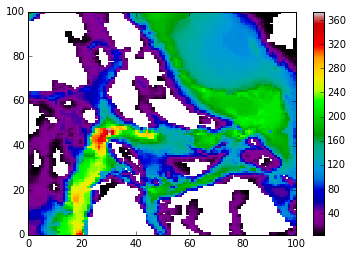

In [8]:
# plot the bottom depth for a region
xs = 300; xe=400; ys = 220; ye=320
plt.pcolormesh(bottom[xs:xe,ys:ye], cmap='spectral')
plt.colorbar()

 ...]

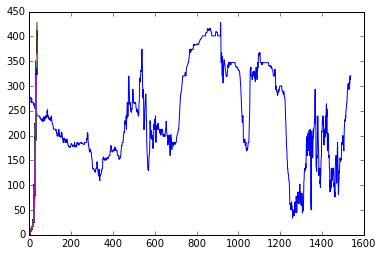

In [12]:
# find the values along the thalweg
thalweg_bottom = bottom[lines[:,0],lines[:,1]]
thalweg_floor = floor[:,lines[:,0],lines[:,1]]
thalweg_ceil = ceil[:,lines[:,0],lines[:,1]]
plt.plot(thalweg_bottom)
plt.plot(thalweg_floor)
plt.plot(thalweg_ceil)

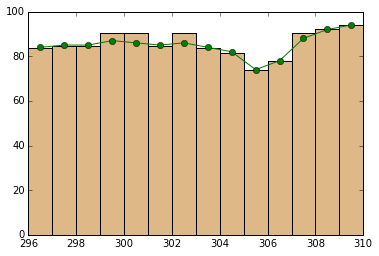

In [10]:
# compare the NEMO bottom values(bar) and the specified depths(green points)
cut = 76
extra = -10
plt.bar(range(ys+cut,ye+extra),200-bottom[xs+80,ys+cut:ye+extra],width=1,color='burlywood')
plt.plot(np.arange(ys+cut,ye+extra)+0.5,200-spec_depth[xs+80,ys+cut:ye+extra],'o-g')

/home/sallen/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


<matplotlib.contour.QuadContourSet instance at 0x7f9af0899128>

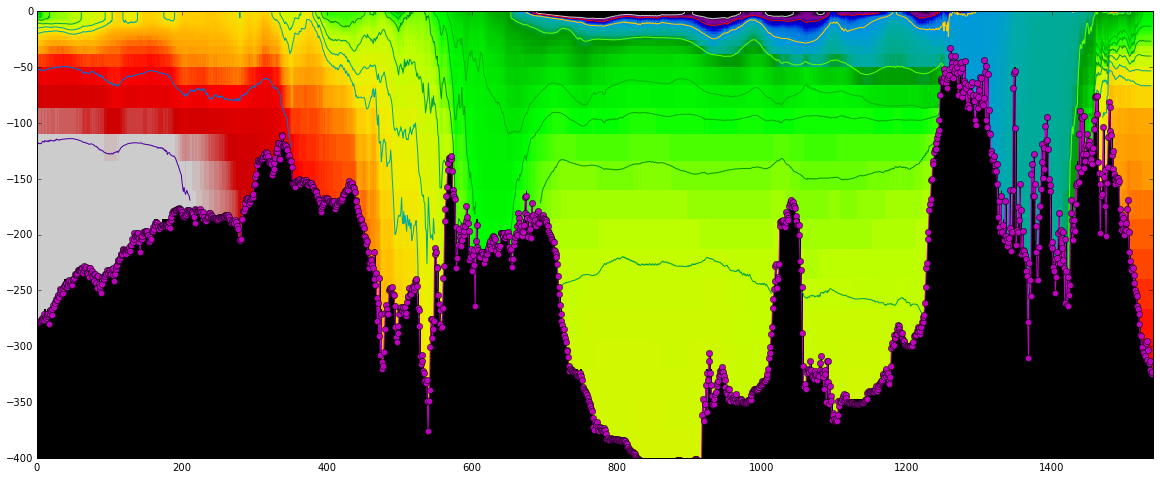

In [11]:
# plot the salinity, the specified bathy and the NEMO bathy along the whole thalweg
xs =000; xe=len(thalweg_spec)
fig, ax = plt.subplots(1, 1, figsize=(20,8))
cmap = plt.get_cmap('spectral') 
cNorm  = colors.Normalize(vmin=26, vmax=33)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

for i in range(xs,xe):
    for k in range(40):
        rect = mpatches.Rectangle([i, -thalweg_floor[k,i]], 1., thalweg_floor[k,i]-thalweg_ceil[k,i], color=scalarMap.to_rgba(salP[k,i]))
        ax.add_patch(rect)

ax.set_xlim((xs,xe))
ax.set_ylim((-400,0))
ax.plot(np.arange(xs,xe)+0.5,-thalweg_spec[xs:xe],'m-o')
ax.bar(np.arange(xs,xe), 400-thalweg_bottom[xs:xe], width=1, bottom = -400, color='burlywood');
ax.contour(XX, -thalweg_depth, salP, cs, cmap='spectral_r')


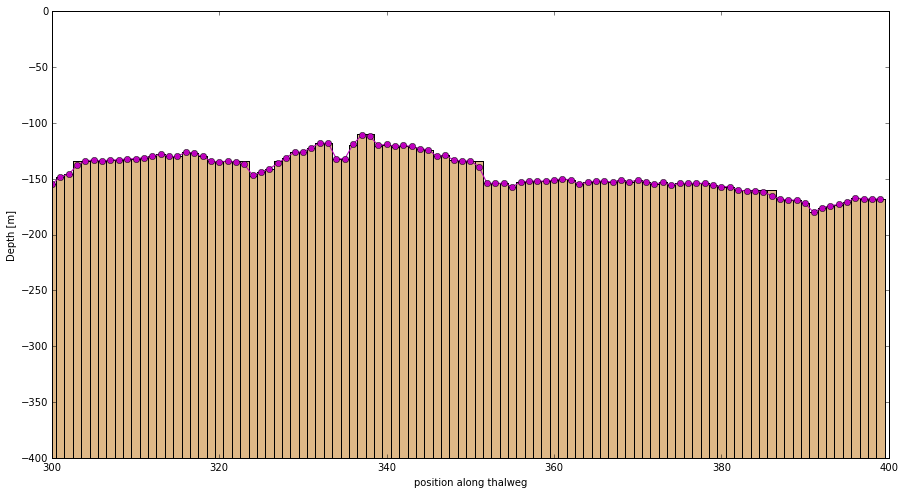

In [12]:
# zoom in
fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(np.arange(300,400),-thalweg_spec[300:400],'m-o')

ax.set_ylabel('Depth [m]')
ax.set_xlabel('position along thalweg')
ax.set_xlim((300,400))
ax.set_ylim((-400,0))
ax.bar(np.arange(300,400)-0.5, 400-thalweg_bottom[300:400], width=1, bottom = -400, color='burlywood');

On old version: Something peculiar happening around thalweg point 330! which is (297, 240)

Now: everything looks fine

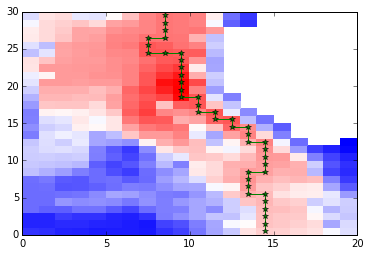

In [13]:
xs = 280; ys=230
st = 450; et = 490
plt.pcolormesh(bottom[xs:310,ys:250],cmap='bwr')
plt.plot(lines[st:et,1]-ys+0.5,lines[st:et,0]-xs+0.5,'g-*')

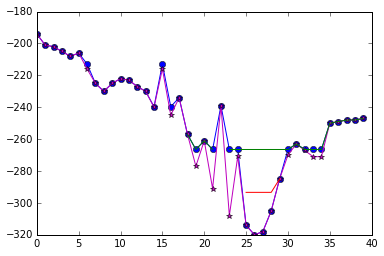

In [14]:
plt.plot(-bottom[lines[st:et,0],lines[st:et,1]],'o-')
plt.plot(-thalweg_spec[st:et],'m*-')
plt.plot(-floor[32,lines[st:et,0],lines[st:et,1]]);
plt.plot(-floor[33,lines[st:et,0],lines[st:et,1]]);

In [15]:
print bottom[lines[st:et,0],lines[st:et,1]]

[194.06314206123352 201.03036618232727 202.02566647529602
 205.01162838935852 207.99759030342102 206.0069591999054 212.8712170124054
 225.02239871025085 230.01028323173523 225.02239871025085
 222.02969241142273 223.02725100517273 227.01754641532898
 230.01028323173523 239.63992190361023 212.8712170124054 239.63992190361023
 234.00057864189148 257.0051281452179 266.48846554756165 261.0001232624054
 266.48846554756165 238.98846316337585 266.48846554756165
 266.48846554756165 314.00030636787415 319.99835324287415
 317.99896359443665 305.0032970905304 285.00189089775085 266.48846554756165
 262.99762082099915 266.48846554756165 266.48846554756165
 266.48846554756165 250.01385617256165 249.01510739326477 248.0163586139679
 248.0163586139679 247.01760983467102]


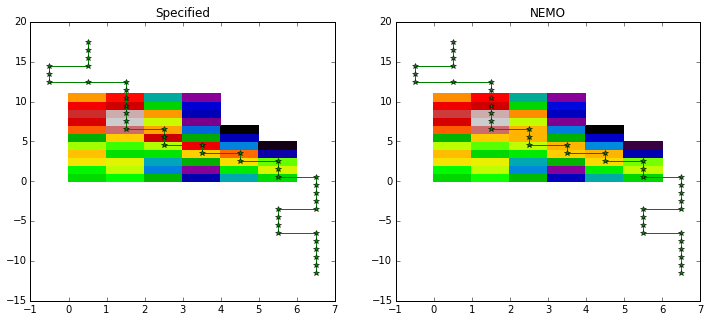

In [16]:
xs = 292; ys=238
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[1].pcolormesh(bottom[xs:303,ys:244],cmap='spectral')
axs[0].pcolormesh(spec_depth[xs:303,ys:244],cmap='spectral')
axs[0].set_title('Specified')
axs[1].set_title('NEMO')
axs[0].plot(lines[st:et,1]-ys+0.5,lines[st:et,0]-xs+0.5,'g-*')
axs[1].plot(lines[st:et,1]-ys+0.5,lines[st:et,0]-xs+0.5,'g-*')

Old: So NEMO is cutting these off because they are isolated (in x and y) even though they are connected in the diagonal. Given the c-grid, this makes sense.  So the thalweg should also not go diagonally.
New: Substantial smoothing of thalweg due to removal of isolated pools.

## Look at the Deepest Points

In [17]:
print bottom.max()
print spec_depth[:].max()
print np.unravel_index(bottom.argmax(), [898,398])

427.999818087
428.0
(533, 204)


<matplotlib.colorbar.Colorbar instance at 0x7f9b46f6c488>

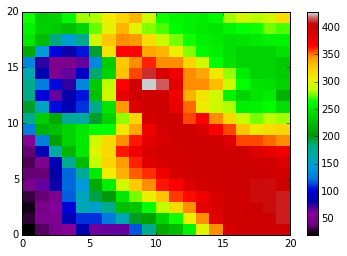

In [18]:
# plot the bottom depth for a region
xs = 520; xe=540; ys = 195; ye=215
plt.pcolormesh(bottom[xs:xe,ys:ye], cmap='spectral')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f9b4616b9e0>

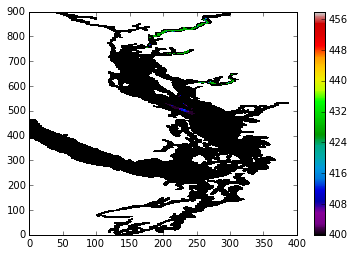

In [19]:
plt.pcolormesh(bottom, vmax = 458, vmin =400, cmap = 'spectral')
plt.colorbar()

In [20]:
def add_bathy(XX, lines, ax):
    baseline = 450.00
    # read bathy
    nc_filepath = '/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/grid_bathy.nc'
    #nc_filepath = '/ocean/nsoontie/MEOPAR/sprint/bathy_meter_SalishSea2.nc'
    bathy = nc.Dataset(nc_filepath, 'r')
    depth = bathy.variables['grid_bathy']
    # Get the depth
    floor = np.empty_like(depth)
    ceil = np.empty_like(depth)
    ceil[0] = 0.
    for k in range(1,40):
        ceil[k] = floor[k-1]
        floor[k] = 2*depth[k] -floor[k-1]
    # find the actual bottom depth
    bottom = np.max(floor, axis=0)
    # find the values along the thalweg
    thalweg_bottom = bottom[lines[:,0],lines[:,1]]
    # draw
    xs = XX.min()
    xe = XX.max()
    ax.bar(np.arange(xs, xe), baseline-thalweg_bottom[xs:xe], width=1, bottom = -1*baseline, color='burlywood');

In [ ]:
# plot the salinity, the specified bathy and the NEMO bathy along the whole thalweg
xs =000; xe=len(thalweg_spec)
fig, ax = plt.subplots(1, 1, figsize=(20,8))
cmap = plt.get_cmap('spectral') 
cNorm  = colors.Normalize(vmin=26, vmax=33)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

for i in range(xs,xe):
    for k in range(40):
        rect = mpatches.Rectangle([i, -thalweg_floor[k,i]], 1., thalweg_floor[k,i]-thalweg_ceil[k,i], color=scalarMap.to_rgba(salP[k,i]))
        ax.add_patch(rect)

ax.set_xlim((xs,xe))
ax.set_ylim((-400,0))
#ax.plot(np.arange(xs,xe)+0.5,-thalweg_spec[xs:xe],'m-o')
ax.bar(np.arange(xs,xe), 400-thalweg_bottom[xs:xe], width=1, bottom = -400, color='burlywood');
ax.contour(XX, -thalweg_depth, salP, cs, cmap='spectral_r')
